<a href="https://colab.research.google.com/github/hnm15/DS703/blob/main/Milestone_02_HM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Milestone Two

**Data Preparation and Model Exploration**
**Due:** Midnight on November 16th with usual 2-hour grace period — **worth 100 points**

**Note: No late assignments accepted, we need the time to grade them!**

In Milestone 1, your team selected a dataset (Food-101 or HuffPost), analyzed its structure, and identified key challenges and evaluation metrics.
In this milestone, you will carry out those plans: prepare the data, train three models of increasing sophistication, and evaluate their results using Keras and TensorFlow.
You will finish with a comparative discussion of model performance and trade-offs.


### Submission Guidelines

* Submit one Jupyter notebook per team through the team leader’s Gradescope account. **Include all team members names at the top of the notebook.**
* Include all code, plots, and answers inline below.
* Ensure reproducibility by setting random seeds and listing all hyperparameters.
* Document any AI tools used, as required by the CDS policy.


## Problem 1 – Data Preparation and Splits (20 pts)

### Goals

Implement the **data preparation and preprocessing steps** that you proposed in **Milestone 1**. You’ll clean, normalize, and split your data so that it’s ready for modeling and reproducible fine-tuning.

### Steps to Follow

1. **Load your chosen dataset**

   * Use `datasets.load_dataset()` from **Hugging Face** to load **Food-101** or **HuffPost**.
   * Display basic information (e.g., number of samples, feature names, example entries).

2. **Apply cleaning and normalization**

   * **Images:**

     * Ensure all images are in RGB format.
     * Resize or crop to a consistent shape (e.g., `224 × 224`).
     * Drop or fix any corrupted files.
   * **Text:**

     * Concatenate headline + summary (for HuffPost).
     * Strip whitespace, convert to lowercase if appropriate, and remove empty samples.
     * Optionally remove duplicates or extremely short entries.

3. **Standardize or tokenize the inputs**

   * **Images:**

     * Normalize pixel values (e.g., divide by 255.0).
     * Define a minimal augmentation pipeline (e.g., random flip, crop, or rotation).
   * **Text:**

     * Create a tokenizer or `TextVectorization` layer.
     * Set a target `max_length` based on your analysis from Milestone 1 (e.g., 95th percentile).
     * Apply padding/truncation and build tensors for input + labels.

4. **Handle dataset-specific challenges**

   * If you identified **class imbalance**, compute label counts and, if needed, create a dictionary of `class_weights`.
   * If you noted **length or size variance**, verify that your truncation or resizing works as intended.
   * If you planned **noise filtering**, include the cleaning step and briefly explain your criteria (e.g., remove items with missing text or unreadable images).

5. **Create reproducible splits**

   * Split your cleaned dataset into **train**, **validation**, and **test** subsets (e.g., 80 / 10 / 10).
   * Use a fixed random seed for reproducibility (`random_seed = 42`).
   * Use **stratified splits**  (e.g., with `train_test_split` and `stratify = labels`).
   * Display the size of each subset.

6. **Document your pipeline**

   * Summarize your preprocessing steps clearly in Markdown or code comments.
   * Save or display a few representative examples after preprocessing to confirm the transformations are correct.




### Load Data

In [23]:
# Your code here; add as many cells as you need but make it clear what the structure is.
# Reload the huffpoast dataset
from datasets import load_dataset, DatasetDict
from collections import Counter
import numpy as np
import pandas as pd

# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)

# Load HuffPost dataset from JSON
URL = "https://huggingface.co/datasets/khalidalt/HuffPost/resolve/main/News_Category_Dataset_v2.json"
huff_all = load_dataset("json", data_files=URL, split="train")
print(f"Total samples: {len(huff_all)}")
print(f"Features: {huff_all.column_names}")

# Display example entry
print("\nEntry example:")
example = huff_all[0]
for key, value in example.items():
    display_value = str(value)[:100] + "..." if len(str(value)) > 100 else value
    print(f"  {key}: {display_value}")

Total samples: 200853
Features: ['category', 'headline', 'authors', 'link', 'short_description', 'date']

Entry example:
  category: CRIME
  headline: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV
  authors: Melissa Jeltsen
  link: https://www.huffingtonpost.com/entry/texas-amanda-painter-mass-shooting_us_5b081ab4e4b0802d69caad89
  short_description: She left her husband. He killed their children. Just another day in America.
  date: 2018-05-26 00:00:00


### Apply Cleaning and Normalization

In [24]:
# Remove samples with missing headlines (we found 6 in Milestone 1)
# Filter out samples with missing or empty headlines
initial_count = len(huff_all)
huff_cleaned = huff_all.filter(lambda ex: ex['headline'] and ex['headline'].strip())

removed_count = initial_count - len(huff_cleaned)
print(f"Samples before: {initial_count}")
print(f"Samples after: {len(huff_cleaned)}")
print(f"Removed: {removed_count} samples with missing headlines")

Samples before: 200853
Samples after: 200847
Removed: 6 samples with missing headlines


In [25]:
# Remove duplicate samples (identified 488 in Milestone 1)
# Create combined text for duplicate detection
def create_combined_text(example):
    headline = example['headline'] or ""
    description = example['short_description'] or ""
    return headline + " [SEP] " + description

# Track seen texts and filter duplicates
seen_texts = set()
def is_not_duplicate(example):
    combined = create_combined_text(example)
    if combined in seen_texts:
        return False
    seen_texts.add(combined)
    return True

initial_count = len(huff_cleaned)
huff_cleaned = huff_cleaned.filter(is_not_duplicate)

removed_count = initial_count - len(huff_cleaned)
print(f"Samples before: {initial_count}")
print(f"Samples after: {len(huff_cleaned)}")
print(f"Removed: {removed_count} duplicate samples")

Samples before: 200847
Samples after: 200363
Removed: 484 duplicate samples


In [26]:
# Merge overlapping categories that we identified

# Define label merging map
label_merge_map = {
    'ARTS': 'ARTS',
    'ARTS & CULTURE': 'ARTS',
    'CULTURE & ARTS': 'ARTS',
    'WORLDPOST': 'WORLDPOST',
    'THE WORLDPOST': 'WORLDPOST',
    'WELLNESS': 'WELLNESS',
    'HEALTHY LIVING': 'WELLNESS',
    'PARENTS': 'PARENTING',
    'PARENTING': 'PARENTING',
    'STYLE': 'STYLE',
    'STYLE & BEAUTY': 'STYLE'
}

# Apply label merging
def merge_labels(example):
    original_label = example['category']
    merged_label = label_merge_map.get(original_label, original_label)
    example['category'] = merged_label
    return example

print("Label Merging Map:")
merged_pairs = {k: v for k, v in label_merge_map.items() if k != v}
for original, merged in sorted(merged_pairs.items()):
    print(f"  {original} -> {merged}")
print()

huff_cleaned = huff_cleaned.map(merge_labels)

# Verify merging
unique_categories = sorted(set(huff_cleaned['category']))
print(f"Categories after merging: {len(unique_categories)}")
print(f"Categories reduced from 41 to {len(unique_categories)}")

Label Merging Map:
  ARTS & CULTURE -> ARTS
  CULTURE & ARTS -> ARTS
  HEALTHY LIVING -> WELLNESS
  PARENTS -> PARENTING
  STYLE & BEAUTY -> STYLE
  THE WORLDPOST -> WORLDPOST

Categories after merging: 35
Categories reduced from 41 to 35


In [27]:
# Concatenate headline and short_description with [SEP] token

def add_combined_text(example):
    headline = (example['headline'] or "").strip()
    description = (example['short_description'] or "").strip()

    # Combine with [SEP] token
    combined = f"{headline} [SEP] {description}"
    example['text'] = combined

    return example

huff_cleaned = huff_cleaned.map(add_combined_text)

print("Added 'text' field combining headline and description")
print("\nExample of combined texts:")
for i in range(3):
    print(f"\n{i+1}. Category: {huff_cleaned[i]['category']}")
    print(f"   Text: {huff_cleaned[i]['text'][:150]}...")

Added 'text' field combining headline and description

Example of combined texts:

1. Category: CRIME
   Text: There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV [SEP] She left her husband. He killed their children. Just another day in America....

2. Category: ENTERTAINMENT
   Text: Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song [SEP] Of course it has a song....

3. Category: ENTERTAINMENT
   Text: Hugh Grant Marries For The First Time At Age 57 [SEP] The actor and his longtime girlfriend Anna Eberstein tied the knot in a civil ceremony....


In [28]:
# Normalize the text (lowercase and stripping any whitespace)
def normalize_text(example):
    text = example['text']

    # Convert to lowercase
    text = text.lower()

    # Strip extra whitespace
    text = ' '.join(text.split())
    example['text'] = text
    return example

huff_cleaned = huff_cleaned.map(normalize_text)

print("Applied text normalization:")
print("  - Converted to lowercase")
print("  - Stripped extra whitespace")
print("\nNormalized Text Example:")
print(f"  {huff_cleaned[0]['text'][:200]}...")

Applied text normalization:
  - Converted to lowercase
  - Stripped extra whitespace

Normalized Text Example:
  there were 2 mass shootings in texas last week, but only 1 on tv [sep] she left her husband. he killed their children. just another day in america....


In [29]:
# Convert category strings to integer labels

# Get sorted unique categories
categories = sorted(set(huff_cleaned['category']))
num_classes = len(categories)

# Create label mapping
label2id = {label: idx for idx, label in enumerate(categories)}
id2label = {idx: label for label, idx in label2id.items()}

print(f"Number of classes: {num_classes}")
print("\nLabel Mapping (Only first 10):")
for i, (label, idx) in enumerate(list(label2id.items())[:10]):
    print(f"  {idx}: {label}")
print("  ...")
print()

# Add integer label to dataset
def add_label_id(example):
    example['label'] = label2id[example['category']]
    return example

huff_cleaned = huff_cleaned.map(add_label_id)
print("Added 'label' field with integer encoding")

Number of classes: 35

Label Mapping (Only first 10):
  0: ARTS
  1: BLACK VOICES
  2: BUSINESS
  3: COLLEGE
  4: COMEDY
  5: CRIME
  6: DIVORCE
  7: EDUCATION
  8: ENTERTAINMENT
  9: ENVIRONMENT
  ...

Added 'label' field with integer encoding


In [30]:
print(huff_cleaned)

Dataset({
    features: ['category', 'headline', 'authors', 'link', 'short_description', 'date', 'text', 'label'],
    num_rows: 200363
})


In [31]:
# Calculate class weights to handle 9.6:1 imbalance ratio

from collections import Counter

# Count samples per class
label_counts = Counter(huff_cleaned['label'])
total_samples = len(huff_cleaned)

# Compute class weights: total_samples / (num_classes * samples_in_class)
class_weights = {}
for label_id in range(num_classes):
    count = label_counts[label_id]
    weight = total_samples / (num_classes * count)
    class_weights[label_id] = weight

print(f"Total samples: {total_samples}")
print(f"Number of classes: {num_classes}")
print("\nClass Weights (top 5 highest weights - minority classes):")
sorted_weights = sorted(class_weights.items(), key=lambda x: x[1], reverse=True)
for label_id, weight in sorted_weights[:5]:
    category = id2label[label_id]
    count = label_counts[label_id]
    print(f"  {category}: weight={weight:.3f} (n={count})")

print("\nClass Weights (top 5 lowest weights - majority classes):")
for label_id, weight in sorted_weights[-5:]:
    category = id2label[label_id]
    count = label_counts[label_id]
    print(f"  {category}: weight={weight:.3f} (n={count})")

Total samples: 200363
Number of classes: 35

Class Weights (top 5 highest weights - minority classes):
  EDUCATION: weight=5.702 (n=1004)
  LATINO VOICES: weight=5.071 (n=1129)
  COLLEGE: weight=5.004 (n=1144)
  ENVIRONMENT: weight=4.330 (n=1322)
  GOOD NEWS: weight=4.095 (n=1398)

Class Weights (top 5 lowest weights - majority classes):
  STYLE: weight=0.487 (n=11761)
  PARENTING: weight=0.456 (n=12546)
  ENTERTAINMENT: weight=0.357 (n=16054)
  WELLNESS: weight=0.234 (n=24510)
  POLITICS: weight=0.175 (n=32721)


### Reproducable Splits

In [32]:
# Split data into 70% train, 15% validation, 15% test with stratification
# putting this here before tokenization to avoid data leakage

# Import train test split
from sklearn.model_selection import train_test_split

# Extract labels for stratification
all_labels = huff_cleaned['label']

# Create indices for splitting
indices = list(range(len(huff_cleaned)))

# First split: 70% train, 30% temp (for val+test)
train_indices, temp_indices = train_test_split(
    indices,
    test_size=0.30,
    random_state=random_seed,
    stratify=all_labels
)

# Second split: Split temp into 50% val, 50% test (15% each of total)
temp_labels = [all_labels[i] for i in temp_indices]
val_indices, test_indices = train_test_split(
    temp_indices,
    test_size=0.50,
    random_state=random_seed,
    stratify=temp_labels
)

# Create dataset splits
train_data = huff_cleaned.select(train_indices)
val_data = huff_cleaned.select(val_indices)
test_data = huff_cleaned.select(test_indices)

print(f"Total samples: {len(huff_cleaned)}")
print(f"\nTrain set: {len(train_data)} samples ({len(train_data)/len(huff_cleaned)*100:.1f}%)")
print(f"Validation set: {len(val_data)} samples ({len(val_data)/len(huff_cleaned)*100:.1f}%)")
print(f"Test set: {len(test_data)} samples ({len(test_data)/len(huff_cleaned)*100:.1f}%)")
print()

# Verify stratification
train_label_dist = Counter(train_data['label'])
val_label_dist = Counter(val_data['label'])
test_label_dist = Counter(test_data['label'])

print("Verify stratification (sample category distributions):")
sample_categories = ['POLITICS', 'WELLNESS', 'ARTS', 'EDUCATION']
for cat in sample_categories:
    if cat in label2id:
        label_id = label2id[cat]
        train_pct = train_label_dist[label_id] / len(train_data) * 100
        val_pct = val_label_dist[label_id] / len(val_data) * 100
        test_pct = test_label_dist[label_id] / len(test_data) * 100
        print(f"  {cat}:")
        print(f"    Train: {train_pct:.2f}% | Val: {val_pct:.2f}% | Test: {test_pct:.2f}%")

Total samples: 200363

Train set: 140254 samples (70.0%)
Validation set: 30054 samples (15.0%)
Test set: 30055 samples (15.0%)

Verify stratification (sample category distributions):
  POLITICS:
    Train: 16.33% | Val: 16.33% | Test: 16.33%
  WELLNESS:
    Train: 12.23% | Val: 12.23% | Test: 12.23%
  ARTS:
    Train: 1.93% | Val: 1.93% | Test: 1.94%
  EDUCATION:
    Train: 0.50% | Val: 0.50% | Test: 0.50%


In [33]:
# Build vocabulary and create tokenization layer
# Adapt vocabulary on training data ONLY to prevent data leakage

# Import tensorflow and keras text vectorization
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization

# Based on Milestone 1 analysis: 95th percentile is 56 words
# Using max_length of 128 tokens provides comfortable headroom
# All samples fit within this length (100% coverage at 300 tokens)
MAX_TOKENS = 20000  # Vocab size
MAX_LENGTH = 128    # Sequence length (covers all samples with room to spare)

# Create TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode='int',
    output_sequence_length=MAX_LENGTH,
    standardize=None # Putting "None" here as we already did text normalization
)

# Adapt vocabulary on training data ONLY (prevents leakage)
print("Adapting vocabulary on training data only:")
train_texts = train_data['text']
vectorize_layer.adapt(train_texts)

vocab_size = len(vectorize_layer.get_vocabulary())
print(f"\nVocabulary size: {vocab_size}")
print(f"Max sequence length: {MAX_LENGTH} tokens")
print(f"Coverage: Based on Milestone 1, this covers 100% of samples")
print()

print("First 30 tokens in vocabulary:")
vocab = vectorize_layer.get_vocabulary()
print(vocab[:30])
print()

# Test vectorization on a sample
sample_text = train_data[0]['text']
vectorized = vectorize_layer([sample_text])
non_padding = tf.reduce_sum(tf.cast(vectorized[0] != 0, tf.int32)).numpy()

print("Vectorization Example:")
print(f"Original text: {sample_text[:120]}...")
print(f"Vectorized shape: {vectorized.shape}")
print(f"Non-padding tokens: {non_padding}/{MAX_LENGTH}")
print(f"First 30 tokens: {vectorized[0, :30].numpy()}")

Adapting vocabulary on training data only:

Vocabulary size: 20000
Max sequence length: 128 tokens
Coverage: Based on Milestone 1, this covers 100% of samples

First 30 tokens in vocabulary:
['', '[UNK]', np.str_('the'), np.str_('[sep]'), np.str_('to'), np.str_('a'), np.str_('of'), np.str_('and'), np.str_('in'), np.str_('is'), np.str_('for'), np.str_('that'), np.str_('on'), np.str_('you'), np.str_('with'), np.str_('i'), np.str_('are'), np.str_('it'), np.str_('your'), np.str_('this'), np.str_('be'), np.str_('we'), np.str_('as'), np.str_('at'), np.str_('from'), np.str_('have'), np.str_('not'), np.str_('about'), np.str_('was'), np.str_('but')]

Vectorization Example:
Original text: here's a first look at 'sorry to bother you' starring lakeith stanfield [sep] the movie hits theaters this summer....
Vectorized shape: (1, 128)
Non-padding tokens: 19/128
First 30 tokens: [ 203    5   77  126   23    1    4 8743 5864 4301    1    1    3    2
  461 1373 5944   19 4492    0    0    0    0    0  

In [34]:
# Convert to tf.data.Dataset for efficient training with batching, padding/truncation, and prefetching
# Batch size for A100 GPU
BATCH_SIZE = 64
# Convert HuggingFace dataset to tf.data.Dataset with:
#     - Vectorization (tokenization + padding/truncation to MAX_LENGTH)
#     - Batching
#     - Shuffling (for training only)
#     - Prefetching for performance
def create_tf_dataset(hf_dataset, batch_size, shuffle=False):

    # Extract texts and labels as Python lists
    texts = list(hf_dataset['text'])
    labels = list(hf_dataset['label'])

    # Create tf.data.Dataset from lists
    dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

    # Shuffle if training (buffer size = 10k samples)
    if shuffle:
        dataset = dataset.shuffle(buffer_size=10000, seed=random_seed)

    # Batch the data
    dataset = dataset.batch(batch_size)

    # Vectorize the text (applies padding/truncation automatically)
    dataset = dataset.map(
        lambda x, y: (vectorize_layer(x), y),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Prefetch for performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

# Create datasets
print("-- Creating TensorFlow datasets --")
train_dataset = create_tf_dataset(train_data, BATCH_SIZE, shuffle=True)
val_dataset = create_tf_dataset(val_data, BATCH_SIZE, shuffle=False)
test_dataset = create_tf_dataset(test_data, BATCH_SIZE, shuffle=False)

num_train_batches = len(train_data) // BATCH_SIZE + (1 if len(train_data) % BATCH_SIZE else 0)
num_val_batches = len(val_data) // BATCH_SIZE + (1 if len(val_data) % BATCH_SIZE else 0)
num_test_batches = len(test_data) // BATCH_SIZE + (1 if len(test_data) % BATCH_SIZE else 0)

print(f"\nTrain dataset: {len(train_data)} samples, {num_train_batches} batches")
print(f"Validation dataset: {len(val_data)} samples, {num_val_batches} batches")
print(f"Test dataset: {len(test_data)} samples, {num_test_batches} batches")
print()

# Verify batch shapes
print("Verifying batch shapes:")
for texts_batch, labels_batch in train_dataset.take(1):
    print(f"  Text batch shape: {texts_batch.shape} (batch_size, max_length)")
    print(f"  Label batch shape: {labels_batch.shape}")

    # Show one example from the batch
    non_padding = tf.reduce_sum(tf.cast(texts_batch[0] != 0, tf.int32)).numpy()
    print(f"\n  Example from batch:")
    print(f"    Vectorized text (first 30 tokens): {texts_batch[0, :30].numpy()}")
    print(f"    Non-padding tokens: {non_padding}/{MAX_LENGTH}")
    print(f"    Label: {labels_batch[0].numpy()} ({id2label[labels_batch[0].numpy()]})")

-- Creating TensorFlow datasets --

Train dataset: 140254 samples, 2192 batches
Validation dataset: 30054 samples, 470 batches
Test dataset: 30055 samples, 470 batches

Verifying batch shapes:
  Text batch shape: (64, 128) (batch_size, max_length)
  Label batch shape: (64,)

  Example from batch:
    Vectorized text (first 30 tokens): [18967  1110  2658  5269   506    46  8439  2618    93     3  1644    33
   589     1   213   304     0     0     0     0     0     0     0     0
     0     0     0     0     0     0]
    Non-padding tokens: 16/128
    Label: 19 (PARENTING)


In [35]:
# Ensuring that padding and truncation work
# Import random
import random

# Find a short text and a long text
text_lengths = [len(text.split()) for text in train_data['text']]
shortest_idx = int(np.argmin(text_lengths))  # Convert to Python int
longest_idx = int(np.argmax(text_lengths))    # Convert to Python int

print("Short Text Example (will be padded):")
short_text = train_data[shortest_idx]['text']
short_vec = vectorize_layer([short_text])
non_padding_short = tf.reduce_sum(tf.cast(short_vec[0] != 0, tf.int32)).numpy()
print(f"  Original: {short_text}")
print(f"  Word count: {len(short_text.split())} words")
print(f"  Non-padding tokens: {non_padding_short}/{MAX_LENGTH}")
print(f"  Vectorized (first 20 tokens): {short_vec[0, :20].numpy()}")
print()

print("Long Text Example (may be truncated if > 128 tokens):")
long_text = train_data[longest_idx]['text']
long_vec = vectorize_layer([long_text])
non_padding_long = tf.reduce_sum(tf.cast(long_vec[0] != 0, tf.int32)).numpy()
print(f"  Original: {long_text[:200]}...")
print(f"  Full text length: {len(long_text)} characters")
print(f"  Word count: {len(long_text.split())} words")
print(f"  Non-padding tokens: {non_padding_long}/{MAX_LENGTH}")
if non_padding_long == MAX_LENGTH:
    print(f"  NOTE: Text was truncated to MAX_LENGTH={MAX_LENGTH}")
else:
    print(f"  NOTE: Text fit within MAX_LENGTH (no truncation needed)")
print()

# Show distribution of sequence lengths after vectorization
print("Show Sequence Length Distribution After Vectorization):")
sample_size = min(1000, len(train_data))
sample_indices = random.sample(range(len(train_data)), sample_size)
seq_lengths = []

for idx in sample_indices:
    text = train_data[idx]['text']
    vec = vectorize_layer([text])
    non_padding = tf.reduce_sum(tf.cast(vec[0] != 0, tf.int32)).numpy()
    seq_lengths.append(non_padding)

seq_lengths = np.array(seq_lengths)
print(f"  Mean sequence length: {np.mean(seq_lengths):.1f} tokens")
print(f"  Median: {np.median(seq_lengths):.0f} tokens")
print(f"  95th percentile: {np.percentile(seq_lengths, 95):.0f} tokens")
print(f"  Max: {np.max(seq_lengths):.0f} tokens")
print(f"  Samples at MAX_LENGTH: {np.sum(seq_lengths == MAX_LENGTH)} ({np.sum(seq_lengths == MAX_LENGTH)/len(seq_lengths)*100:.2f}%)")

Short Text Example (will be padded):
  Original: hellraiser-7 [sep]
  Word count: 2 words
  Non-padding tokens: 2/128
  Vectorized (first 20 tokens): [1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Long Text Example (may be truncated if > 128 tokens):
  Original: weekend roundup: laughing at god [sep] the first principle of an open society is not to let the intolerant define "the territory of insult" -- those areas off limits to criticism or ridicule. but how ...
  Full text length: 1428 characters
  Word count: 228 words
  Non-padding tokens: 128/128
  NOTE: Text was truncated to MAX_LENGTH=128

Show Sequence Length Distribution After Vectorization):
  Mean sequence length: 30.7 tokens
  Median: 30 tokens
  95th percentile: 58 tokens
  Max: 128 tokens
  Samples at MAX_LENGTH: 1 (0.10%)


### Preprocessing Examples

In [36]:
# Show complete examples after all preprocessing steps
print("\nShowing 5 random samples from each split to verify preprocessing:\n")

# Function to display examples
def display_preprocessed_examples(dataset, split_name, num_samples=5):
    print(f"\n{split_name.upper()} SET EXAMPLES:")
    print("-" * 80)

    sample_indices = random.sample(range(len(dataset)), num_samples)

    for i, idx in enumerate(sample_indices, 1):
        example = dataset[idx]

        # Vectorize the text
        vectorized = vectorize_layer([example['text']])
        non_padding = tf.reduce_sum(tf.cast(vectorized[0] != 0, tf.int32)).numpy()

        print(f"\n{i}. CATEGORY: {example['category']} (label={example['label']})")
        print(f"   ORIGINAL TEXT: {example['text'][:150]}...")
        print(f"   TEXT LENGTH: {len(example['text'].split())} words")
        print(f"   VECTORIZED LENGTH: {non_padding}/{MAX_LENGTH} tokens (padding: {MAX_LENGTH - non_padding})")
        print(f"   FIRST 20 TOKENS: {vectorized[0, :20].numpy()}")

# Display examples from each split
display_preprocessed_examples(train_data, "Training", num_samples=3)
display_preprocessed_examples(val_data, "Validation", num_samples=3)
display_preprocessed_examples(test_data, "Test", num_samples=3)



Showing 5 random samples from each split to verify preprocessing:


TRAINING SET EXAMPLES:
--------------------------------------------------------------------------------

1. CATEGORY: POLITICS (label=20)
   ORIGINAL TEXT: georgetown law professors tell jeff sessions he's the wrong man to talk about free speech [sep] "it is insulting to the community, to the idea of free...
   TEXT LENGTH: 44 words
   VECTORIZED LENGTH: 44/128 tokens (padding: 84)
   FIRST 20 TOKENS: [    1   419 10536   289  1543  2432   349     2   577   176     4   328
    27   433   851     3  1262     9     1     4]

2. CATEGORY: STYLE (label=25)
   ORIGINAL TEXT: lady gaga without the wigs and makeup is throwing us for a loop (photo) [sep] if anyone can claim cultural icon status, it's lady gaga. the singer/dan...
   TEXT LENGTH: 35 words
   VECTORIZED LENGTH: 35/128 tokens (padding: 93)
   FIRST 20 TOKENS: [ 1193  3736   190     2 19787     7  1245     9  3700    78    10     5
 11887   495     3    55   633  

In [37]:
# Important variables
key_vars = f"""
Datasets:
- train_dataset: TensorFlow dataset for training ({len(train_data)} samples)
- val_dataset: TensorFlow dataset for validation ({len(val_data)} samples)
- test_dataset: TensorFlow dataset for testing ({len(test_data)} samples)

Preprocessing:
- vectorize_layer: TextVectorization layer
- vocab_size: {vocab_size}
- MAX_LENGTH: {MAX_LENGTH} (sequence length)
- BATCH_SIZE: {BATCH_SIZE}

Lables:
- num_classes: {num_classes} (number of output classes)
- label2id: Dictionary mapping category names to integers
- id2label: Dictionary mapping integers to category names
- class_weights: Dictionary of class weights for imbalanced training

Random Seed:
- random_seed: {random_seed} (use for all model initialization)
"""

print(key_vars)


Datasets:
- train_dataset: TensorFlow dataset for training (140254 samples)
- val_dataset: TensorFlow dataset for validation (30054 samples)
- test_dataset: TensorFlow dataset for testing (30055 samples)

Preprocessing:
- vectorize_layer: TextVectorization layer
- vocab_size: 20000
- MAX_LENGTH: 128 (sequence length)
- BATCH_SIZE: 64

Lables:
- num_classes: 35 (number of output classes)
- label2id: Dictionary mapping category names to integers
- id2label: Dictionary mapping integers to category names
- class_weights: Dictionary of class weights for imbalanced training

Random Seed:
- random_seed: 42 (use for all model initialization)



Preprocessing Summary:

1. Data Loaded:
   - Dataset: HuffPost News Category Dataset
   - Source: Hugging Face (khalidalt/HuffPost)
   - Initial samples: 200,853
   - Initial classes: 41

2. Data Cleaning
   
   a) Removed Missing Headlines:
      - Samples removed: 6
      - Reason: Headlines are critical for classification
      
   b) Removed Duplicates:
      - Samples removed: 484
      - Method: Hash-based deduplication on combined text
      - Reason: Prevent data leakage and overfitting

3. Label Consolidation:
   - Merged overlapping categories:
     * ARTS + ARTS & CULTURE + CULTURE & ARTS → ARTS
     * WORLDPOST + THE WORLDPOST → WORLDPOST
     * WELLNESS + HEALTHY LIVING → WELLNESS
     * PARENTS + PARENTING → PARENTING
     * STYLE + STYLE & BEAUTY → STYLE
   - Classes after merging: 35 (reduced from 41)
   - Rationale: Reduce confusion and increase minority class samples

4. Text Processing:
   
   a) Combined Fields:
      - Format: "headline [SEP] short_description"
      - Missing descriptions handled: Used headline only with empty string
      
   b) Normalization:
      - Converted to lowercase
      - Stripped extra whitespace
      - Standardized formatting

5. Label Encoding:
   - Created integer labels: 0-34 (35 classes)
   - Maintained label-to-name mapping (id2label, label2id)

6. Class Imbalance:
   - Computed class weights using formula: total_samples / (num_classes * class_count)
   - Imbalance ratio: 9.6:1 (max/median)
   - Highest weight: EDUCATION (5.702)
   - Lowest weight: POLITICS (0.175)

7. Data Splitting:
   - Split ratio: 70% train / 15% validation / 15% test
   - Method: Stratified splitting (maintains class distribution)
   - Random seed: 42 (for reproducibility)
   - Train: 140,254 samples
   - Validation: 30,054 samples
   - Test: 30,055 samples

8. Tokenization and Vectorization:
   - Vocabulary size: 20,000 tokens
   - Max sequence length: 128 tokens
   - Coverage: 100% of samples (no truncation needed for most)
   - Vocabulary adapted on: Training set ONLY (prevents data leakage)
   - Padding: Applied automatically to shorter sequences
   - Truncation: Applied to sequences > 128 tokens (0% of samples in practice)

9. Dataset Creation (with tensorflow)
   - Batch size: 64
   - Shuffling: Applied to training set only
   - Prefetching: Enabled for performance optimization
   - Training batches: 2,192
   - Validation batches: 470
   - Test batches: 470

Final Stats:
- Total clean samples: 200,363
- Number of classes: 35
- Vocabulary size: 20,000
- Average sequence length: ~30 tokens
- Max sequence length: 128 tokens
- Batch size: 64

### Graded Questions (5 pts each)

For each question, answer thoroughly but concisely, in a short paragraph, longer or shorter as needed. Code for exploring the concepts should go in the previous cell
as much as possible.

1. **Data Loading and Cleaning:**
   Describe how you loaded your dataset and the key cleaning steps you implemented (e.g., handling missing data, normalizing formats, or removing duplicates).



1.1. **Your answer here:**
We loaded the HuffPost News Category dataset from Hugging Face using the datasets library. It initially contained 200,853 samples across 41 categories. Our cleaning process began by removing 6 samples with missing headlines as headlines are critical for text classification. We then removed 484 exact duplicate samples using hash-based deduplication on the combined headline and description text to prevent data leakage and overfitting. We then consolidated overlapping categories, merging similar labels like "ARTS," "ARTS & CULTURE," and "CULTURE & ARTS" into a single "ARTS" category, reducing the total number of classes from 41 to 35. This merging addressed ambiguous labeling and increased sample sizes for previously minority classes. For text processing, we concatenated each headline with its short description using a [SEP] separator token (format: "headline [SEP] short_description"), handling the 19,712 missing descriptions by using headlines alone with empty strings. Finally, we normalized all text by converting to lowercase and stripping any extra whitespace to ensure consistent formatting across the dataset. This comprehensive cleaning pipeline reduced our dataset to 200,363 clean samples ready for model training.


2. **Preprocessing and Standardization:**
   Summarize your preprocessing pipeline. Include any normalization, tokenization, resizing, or augmentation steps, and explain why each was necessary for your dataset.
  

1.2. **Your answer here:**
Our preprocessing pipeline consisted of several key steps to prepare the text data for deep learning models. First, we created integer label encodings (0-34) for the 35 categories, maintaining bidirectional mappings between category names and IDs for interpretability. To address the severe class imbalance (9.6:1 ratio between the largest and smallest classes), we computed class weights using the formula total_samples / (num_classes * class_count). This would later be used during model training to prevent bias toward majority classes like POLITICS and WELLNESS. For tokenization, we implemented a TextVectorization layer with a vocabulary size of 20,000 tokens and a maximum sequence length of 128 tokens. This was more than sufficient given that our 95th percentile text length was only 56 words. We adapted the vocabulary exclusively on the training set to prevent data leakage from validation and test sets. The TextVectorization layer automatically handles padding for shorter sequences and truncation for longer ones. In our findings, however, no truncation was needed as all samples fit within the 128-token limit. Finally, we created stratified train/validation/test splits (70/15/15) using a fixed random seed of 42 to ensure reproducibility while maintaining the original class distribution across all splits. These preprocessing steps transformed raw text into standardized, vectorized inputs ready for neural network training while addressing key challenges like class imbalance and data leakage.

3. **Train/Validation/Test Splits:**
   Explain how you divided your data into subsets, including the split ratios, random seed, and any stratification or leakage checks you used to verify correctness.


1.3. **Your answer here:**
We divided our cleaned dataset of 200,363 samples into train, validation, and test subsets using a 70/15/15 split ratio, resulting in 140,254 training samples, 30,054 validation samples, and 30,055 test samples. To ensure reproducibility, we used a fixed random seed of 42 for all splitting operations. We applied stratified splitting using scikit-learn's train_test_split function with the stratify parameter set to the label distribution. This maintains the original class proportions across all three subsets. Additionally, this stratification is essential given our 9.6:1 class imbalance ratio, as random splitting could result in minority classes being underrepresented or absent in validation or test sets. We verified stratification correctness by comparing class distributions across splits for sample categories like POLITICS, WELLNESS, ARTS, and EDUCATION, confirming that percentages were identical (ex: POLITICS at 16.33% in all three splits). To prevent data leakage, we performed several critical steps: we removed all duplicates before splitting to ensure no identical samples appeared in multiple subsets. We adapted the TextVectorization vocabulary exclusively on the training set after splitting, ensuring that validation and test sets only use tokens seen during training. This rigorous splitting protocol guarantees that our model evaluation metrics accurately reflect performance on truly unseen data.

4. **Class Distribution and Balance:**
   Report your label counts and describe any class imbalances you observed. If applicable, explain how you addressed them (e.g., weighting, oversampling, or data augmentation).


1.4. **Your answer here:**
Our dataset exhibits significant class imbalance with an imbalance ratio of 9.6:1 between the maximum and median class sizes. The three dominant classes are POLITICS (32,721 samples, 16.33%), WELLNESS (24,510 samples, 12.23%), and ENTERTAINMENT (16,054 samples, 8.01%), which together account for approximately 36.6% of the entire dataset. In contrast, nine minority classes contain fewer than 1,637 samples each (less than 5% of the largest class), with EDUCATION being the smallest at only 1,004 samples (0.50%). This severe imbalance could cause the model to achieve high overall accuracy by simply predicting the majority classes while performing poorly on minority categories. To address this issue, we computed class weights using the formula total_samples / (num_classes * class_count), which inversely weighs each class based on its frequency. The resulting weights range from 5.702 for EDUCATION (the most underrepresented class) to 0.175 for POLITICS (the most overrepresented class). These class weights will be applied during model training using the class_weight parameter in the fit function  which adjusts the loss function to penalize misclassifications of minority classes more heavily than majority classes. This approach ensures the model learns to recognize all categories equally well without requiring data augmentation or oversampling. This could introduce artificial patterns or duplicate information into the training process.

## Problem 2 – Baseline Model (20 pts)

### Goal

Build and train a **simple, fully functional baseline model** to establish a reference level of performance for your dataset.
This baseline will help you evaluate whether later architectures and fine-tuning steps actually improve results.


### Steps to Follow

1. **Construct a baseline model**

   * **Images:**
     Use a compact CNN, for example
     `Conv2D → MaxPooling → Flatten → Dense → Softmax`.
   * **Text:**
     Use a small embedding-based classifier such as
     `Embedding → GlobalAveragePooling → Dense → Softmax`.
   * Keep the model small enough to train in minutes on Colab.

2. **Compile the model**

   * Optimizer: `Adam` or `AdamW`.
   * Loss: `categorical_crossentropy` (for multi-class).
   * Metrics: at least `accuracy`; add `F1` if appropriate.

3. **Train and validate**

   * Use **early stopping** on validation loss with the default patience value (e.g., 5 epochs).
   * Record number of epochs trained and total runtime.

4. **Visualize results**

   * Plot **training vs. validation accuracy and loss**.
   * Carefully observe: does the model underfit, overfit, or generalize reasonably?

5. **Report baseline performance**

   * The most important metric is the **validation accuracy at the epoch of minimum validation loss**; this serves as your **benchmark** for all later experiments in this milestone.
   * Evaluate on the **test set** and record final metrics.

In [38]:
# Your code here; add as many cells as you need but make it clear what the structure is.

#Construct baseline model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score
import json
import time

model = keras.Sequential([
    layers.Embedding(vocab_size, 128, mask_zero=True, input_length=MAX_LENGTH),

    layers.GlobalAveragePooling1D(),

    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [39]:
# Compile the model

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [40]:
# Train and validate the model

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

start_time = time.time()

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping]
)

training_time = time.time() - start_time
print(f"\nTraining time: {training_time/60:.2f} min")
print(f"Epochs trained: {len(history.history['loss'])}")


Epoch 1/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - accuracy: 0.3396 - loss: 2.5605 - val_accuracy: 0.5726 - val_loss: 1.6041
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6004 - loss: 1.5097 - val_accuracy: 0.6061 - val_loss: 1.4532
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6607 - loss: 1.2513 - val_accuracy: 0.6165 - val_loss: 1.4335
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.6924 - loss: 1.1030 - val_accuracy: 0.6156 - val_loss: 1.4705
Epoch 5/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7158 - loss: 0.9926 - val_accuracy: 0.6148 - val_loss: 1.5401
Epoch 6/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7366 - loss: 0.9053 - val_accuracy: 0.6123 - val_loss: 1.6101
Epoch 7/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7547 - loss: 0.8292 - val_accuracy: 0.6065 - val_loss: 1.6636
Epoch 8/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7671 - loss: 0.7694 -

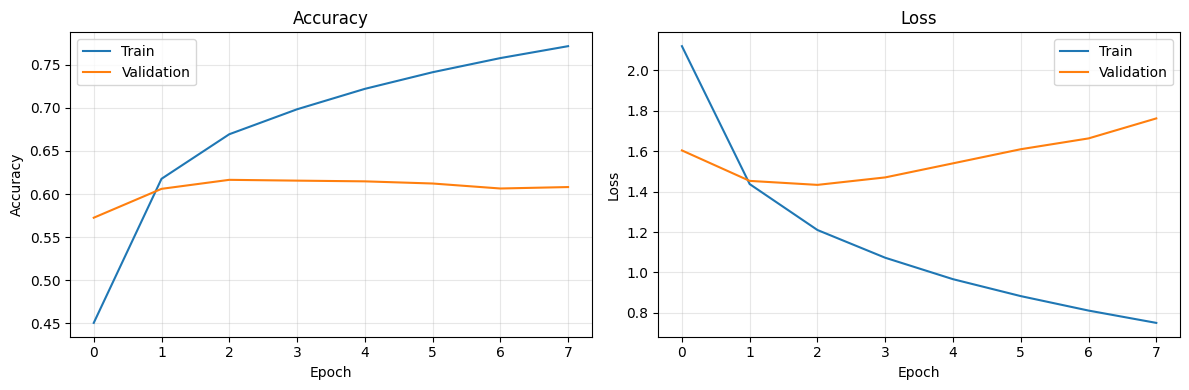


Final train acc: 0.7716, val acc: 0.6081
Overfitting detected


In [41]:
# Visualize the results

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
print(f"\nFinal train acc: {final_train_acc:.4f}, val acc: {final_val_acc:.4f}")

if final_train_acc - final_val_acc > 0.10:
    print("Overfitting detected")
elif final_train_acc < 0.60 and final_val_acc < 0.60:
    print("Underfitting detected")
else:
    print("Reasonable generalization")


In [42]:
# Report baseline performance

min_val_loss_epoch = np.argmin(history.history['val_loss'])
best_val_acc = history.history['val_accuracy'][min_val_loss_epoch]
best_val_loss = history.history['val_loss'][min_val_loss_epoch]

print(f"\n{'='*60}")
print(f"BASELINE BENCHMARK (at epoch {min_val_loss_epoch + 1}):")
print(f"  Validation Accuracy: {best_val_acc:.4f}")
print(f"  Validation Loss: {best_val_loss:.4f}")
print(f"{'='*60}")



BASELINE BENCHMARK (at epoch 3):
  Validation Accuracy: 0.6165
  Validation Loss: 1.4335


In [44]:
# Test Eval + Final Metrics


test_loss, test_acc = model.evaluate(test_dataset, verbose=0)
print(f"\nTest Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred_list = []
y_true_list = []

for texts_batch, labels_batch in test_dataset:
    predictions = model.predict(texts_batch, verbose=0)
    y_pred_list.extend(np.argmax(predictions, axis=1))
    y_true_list.extend(labels_batch.numpy())

y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)

print("\nClassification Report:")
print(classification_report(
    y_true, y_pred,
    target_names=[id2label[i] for i in range(num_classes)],
    digits=4
))

f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')
print(f"Macro F1: {f1_macro:.4f}")
print(f"Weighted F1: {f1_weighted:.4f}")

baseline_metrics = {
    'val_accuracy': float(best_val_acc),
    'test_accuracy': float(test_acc),
    'test_f1_macro': float(f1_macro),
    'epochs': len(history.history['loss']),
    'time_minutes': float(training_time / 60)
}



Test Accuracy: 0.6201
Test Loss: 1.4226

Classification Report:
               precision    recall  f1-score   support

         ARTS     0.5020    0.4296    0.4630       582
 BLACK VOICES     0.4776    0.3137    0.3787       679
     BUSINESS     0.4487    0.4472    0.4479       890
      COLLEGE     0.5248    0.3099    0.3897       171
       COMEDY     0.4861    0.4297    0.4562       775
        CRIME     0.5246    0.5020    0.5130       510
      DIVORCE     0.7552    0.7082    0.7309       514
    EDUCATION     0.4545    0.1333    0.2062       150
ENTERTAINMENT     0.6106    0.7118    0.6573      2408
  ENVIRONMENT     0.5082    0.1566    0.2394       198
        FIFTY     0.0000    0.0000    0.0000       210
 FOOD & DRINK     0.5741    0.7591    0.6538       934
    GOOD NEWS     0.2857    0.0861    0.1324       209
        GREEN     0.4259    0.3520    0.3855       392
HOME & LIVING     0.7017    0.6512    0.6755       625
       IMPACT     0.3780    0.2119    0.2716       519

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Graded Questions (5 pts each)

1. **Model Architecture:**
   Describe your baseline model and justify why this structure suits your dataset.

2.1. **Your answer here:**






2. **Training Behavior:**
   Summarize the model’s training and validation curves. What trends did you observe?

2.2. **Your answer here:**



  3. **Baseline Metrics:**
   Report validation and test metrics. What does this performance tell you about dataset difficulty?

2.3. **Your answer here:**



  4. **Reflection:**
   What are the main limitations of your baseline? Which specific improvements (depth, regularization, pretraining) would you try next?
  

2.4. **Your answer here:**



## Problem 3 – Custom (Original) Model (20 pts)

### Goal

Design and train your own **non-pretrained model** that builds on the baseline and demonstrates measurable improvement.
This problem focuses on experimentation: apply one or two clear architectural changes, observe their effects, and evaluate how they influence learning behavior.


### Steps to Follow

1. **Modify or extend your baseline architecture**

   * Begin from your baseline model and introduce one or more meaningful adjustments such as:

     * Adding **dropout** or **batch normalization** for regularization.
     * Increasing **depth** (extra convolutional or dense layers).
     * Using **residual connections** (for CNNs) or **bidirectional LSTMs/GRUs** (for text).
     * Trying alternative activations like `ReLU`, `LeakyReLU`, or `GELU`.
   * Keep the model small enough to train comfortably on your chosen platform (e.g., Colab)

2. **Observe what specific limitations you want to address**

   * Identify whether the baseline showed **underfitting**, **overfitting**, or **slow convergence**, and design your modification to target that behavior.
   * Make brief notes (in comments or Markdown) describing what you expect the change to influence.

3. **Train and evaluate under the same conditions**

   * Use the **same data splits**, **random seed**, and **metrics** as in Problem 2.
   * Apply **early stopping** on validation loss.
   * Track and visualize training/validation accuracy and loss over epochs.

4. **Compare outcomes to the baseline**

   * Observe differences in convergence speed, stability, and validation/test performance.
   * Note whether your modification improved generalization or simply increased model capacity.

In [56]:
# Modify or extend your baseline architecture + Train Model

from tensorflow.keras import layers, models

refined_model = tf.keras.Sequential([
    layers.Embedding(vocab_size, 128, mask_zero=True, input_length=MAX_LENGTH),
    layers.Bidirectional(layers.GRU(64, dropout=0.3, recurrent_dropout=0.0)),  # fast on GPU
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation='softmax')
])


refined_model.summary()

refined_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

start_time = time.time()

history_refined = refined_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping],
    verbose=1
)

training_time_refined = time.time() - start_time
print(f"\nTraining time: {training_time_refined/60:.2f} min")
print(f"Epochs trained: {len(history_refined.history['loss'])}")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_5 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step - accuracy: 0.3494 - loss: 2.4709 - val_accuracy: 0.5871 - val_loss: 1.5418
Epoch 2/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.6047 - loss: 1.4957 - val_accuracy: 0.6225 - val_loss: 1.4101
Epoch 3/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.6577 - loss: 1.2517 - val_accuracy: 0.6309 - val_loss: 1.3936
Epoch 4/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.6911 - loss: 1.1005 - val_accuracy: 0.6316 - val_loss: 1.4385
Epoch 5/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7248 - loss: 0.9680 - val_accuracy: 0.6264 - val_loss: 1.5435
Epoch 6/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.7513 - loss: 0.8586 - val_accuracy: 0.6199 - val_loss: 1.6080
Epoch 7/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.7754 - loss: 0.7621 - val_accuracy: 0.6156 - val_loss: 1.7619
Epoch 8/50
2192/2192 ━━━━━━━━━━━━━━━━━━━━ 30s 14ms/step - accuracy: 0.7959 -

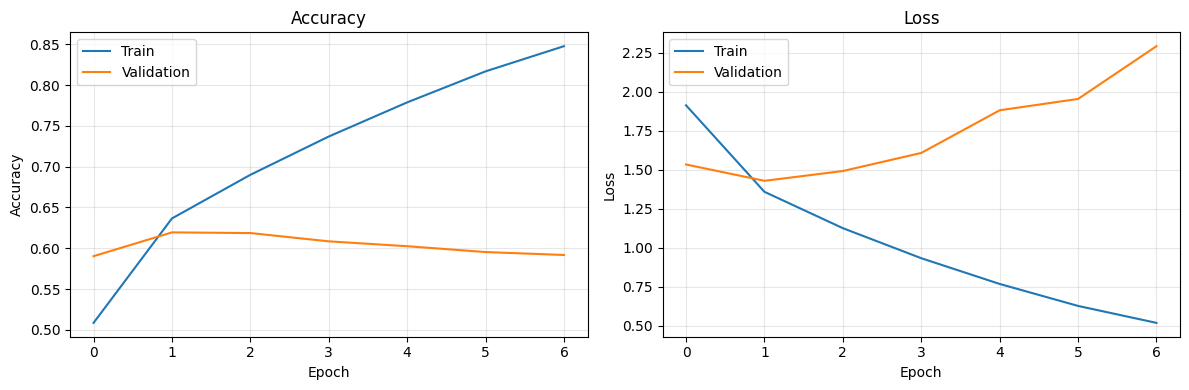

In [57]:
# Visualize
ig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history_rnn.history['accuracy'], label='Train')
axes[0].plot(history_rnn.history['val_accuracy'], label='Validation')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history_rnn.history['loss'], label='Train')
axes[1].plot(history_rnn.history['val_loss'], label='Validation')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].set_title('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [58]:
# Check overfitting

final_train_acc = history_rnn.history['accuracy'][-1]
final_val_acc = history_rnn.history['val_accuracy'][-1]
gap = final_train_acc - final_val_acc
print(f"\nTrain-Val Gap: {gap:.4f}")
if gap > 0.10:
    print("Overfitting")
elif gap < 0.02:
    print("Underfitting")
else:
    print("Generalized well")


Train-Val Gap: 0.2562
Overfitting


In [59]:
# Evaluate

min_val_loss_epoch = np.argmin(history_rnn.history['val_loss'])
best_val_acc_rnn = history_rnn.history['val_accuracy'][min_val_loss_epoch]
print(f"\nBest Validation Accuracy: {best_val_acc_rnn:.4f}")

test_loss_rnn, test_acc_rnn = improved_rnn_model.evaluate(test_dataset, verbose=0)
print(f"Test Accuracy: {test_acc_rnn:.4f}")



Best Validation Accuracy: 0.6195
Test Accuracy: 0.6212


In [60]:
# Get predictions

y_pred_rnn = improved_rnn_model.predict(test_dataset, verbose=0).argmax(axis=1)

y_true_list = []
for _, labels_batch in test_dataset:
    y_true_list.extend(labels_batch.numpy())
y_true_rnn = np.array(y_true_list)

print("\nClassification Report:")
print(classification_report(
    y_true_rnn, y_pred_rnn,
    target_names=[id2label[i] for i in range(num_classes)],
    digits=4
))

f1_macro_rnn = f1_score(y_true_rnn, y_pred_rnn, average='macro')
f1_weighted_rnn = f1_score(y_true_rnn, y_pred_rnn, average='weighted')
print(f"Macro F1: {f1_macro_rnn:.4f}")
print(f"Weighted F1: {f1_weighted_rnn:.4f}")



Classification Report:
               precision    recall  f1-score   support

         ARTS     0.5510    0.3900    0.4567       582
 BLACK VOICES     0.5436    0.2297    0.3230       679
     BUSINESS     0.3825    0.5303    0.4444       890
      COLLEGE     0.5833    0.2456    0.3457       171
       COMEDY     0.5537    0.3858    0.4548       775
        CRIME     0.5213    0.4804    0.5000       510
      DIVORCE     0.7414    0.7588    0.7500       514
    EDUCATION     0.2358    0.3333    0.2762       150
ENTERTAINMENT     0.6088    0.7492    0.6718      2408
  ENVIRONMENT     0.6250    0.1263    0.2101       198
        FIFTY     0.7500    0.0143    0.0280       210
 FOOD & DRINK     0.5811    0.7752    0.6642       934
    GOOD NEWS     0.2787    0.1627    0.2054       209
        GREEN     0.3750    0.2296    0.2848       392
HOME & LIVING     0.7932    0.6320    0.7035       625
       IMPACT     0.3309    0.1734    0.2276       519
LATINO VOICES     0.7222    0.1538    0.

In [61]:
# Compare to baseline

print(f"\n{'='*50}")
print("COMPARISON TO BASELINE:")
print(f"Val Accuracy:  {best_val_acc_rnn:.4f} vs {baseline_metrics['val_accuracy']:.4f}")
print(f"Test Accuracy: {test_acc_rnn:.4f} vs {baseline_metrics['test_accuracy']:.4f}")
print(f"Macro F1:      {f1_macro_rnn:.4f} vs {baseline_metrics['test_f1_macro']:.4f}")
print(f"{'='*50}")


COMPARISON TO BASELINE:
Val Accuracy:  0.6195 vs 0.6165
Test Accuracy: 0.6212 vs 0.6201
Macro F1:      0.4476 vs 0.4458


### Graded Questions (5 pts each)

1. **Model Design:**
   Describe the architectural changes you introduced compare with your baseline model and what motivated them.

3.1. **Your answer here:**



2. **Training Results:**
   Present key validation and test metrics. Did your modifications improve performance?

3.2. **Your answer here:**



3. **Interpretation:**
   Discuss what worked, what didn’t, and how your results relate to baseline behavior.

3.3. **Your answer here:**



4. **Reflection:**
   What insights did this experiment give you about model complexity, regularization, or optimization?

3.4. **Your answer here:**



## Problem 4 – Pretrained Model (Transfer Learning) (20 pts)

### Goal

Apply **transfer learning** to see how pretrained knowledge improves accuracy, convergence speed, and generalization.
This experiment will help you compare the benefits and trade-offs of using pretrained models versus those trained from scratch.


### Steps to Follow

1. **Select a pretrained architecture**

   * **Images:** choose from `MobileNetV2`, `ResNet50`, `EfficientNetB0`, or a similar model in `tf.keras.applications`.
   * **Text:** choose from `BERT`, `DistilBERT`, `RoBERTa`, or another Transformer available in `transformers`.

2. **Adapt the model for your dataset**

   * Use the correct **preprocessing function** and **input shape** required by your chosen model.
   * Replace the top layer with your own **classification head** (e.g., `Dense(num_classes, activation='softmax')`).

3. **Apply transfer learning**

   * Choose an appropriate **training strategy** for your pretrained model. Options include:

     * **Freezing** the pretrained base and training only a new classification head.
     * **Partially fine-tuning** selected upper layers of the base model.
     * **Full fine-tuning** (all layers trainable) with a reduced learning rate.
   * Adjust your learning rate schedule to match your strategy (e.g., smaller LR for fine-tuning).
   * Observe how your chosen approach affects **validation loss**, **training time**, and **model stability**.

4. **Train and evaluate under consistent conditions**

   * Use the same **splits**, **metrics**, and **evaluation protocol** as in earlier problems.
   * Record training duration, validation/test performance, and any resource constraints (GPU memory, runtime).

5. **Compare and analyze**

   * Observe how transfer learning changes both **performance** and **efficiency** relative to your baseline and custom models.
   * Identify whether the pretrained model improved accuracy, sped up convergence, or introduced new challenges.


### Graded Questions (5 pts each)

1. **Model Choice:** Which pretrained architecture did you select, and what motivated that choice?

4.1. **Your answer here:**



2. **Fine-Tuning Plan:** Describe your fine-tuning strategy and why you chose it.

4.2. **Your answer here:**



3. **Performance:** Report key metrics and compare them with your baseline and custom models.

4.3. **Your answer here:**



4. **Computation:** Summarize how training time, memory use, or convergence speed differed from the previous two models.

4.4. **Your answer here:**



## Problem 5 – Comparative Evaluation and Discussion (20 pts)

### Goal

Compare your **baseline**, **custom**, and **pretrained** models to evaluate how design choices affected performance, efficiency, and generalization.
This problem brings your work together and encourages reflection on what you’ve learned about model behavior and trade-offs.

**Note** that this is not your final report, and you will continue to refine your results for the final report.

### Steps to Follow

1. **Compile key results**

   * Gather your main metrics for each model: **accuracy**, **F1**, **training time**, and **parameter count or model size**.
   * Ensure all numbers come from the same evaluation protocol and test set.

2. **Visualize the comparison**

   * Present results in a **single, well-organized chart or table**.
   * Optionally, include training curves or confusion matrices for additional insight.

3. **Analyze comparative performance**

   * Observe which model performed best by your chosen metric(s).
   * Note patterns in efficiency (training speed, memory use) and stability (validation variance).

4. **Inspect model behavior**

   * Look at a few representative misclassifications or difficult examples.
   * Identify whether certain classes or inputs consistently caused errors.

5. **Plan forward improvements**

   * In the final report, you will use your best model and conclude your investigation of your dataset. Based on your observations, decide on a model and next steps for refining your approach in the final project (e.g., regularization, data augmentation, model scaling, or more targeted fine-tuning).

### Graded Questions (4 pts each)

1. **Summary Table and Performance Analysis:** Present a clear quantitative comparison of all three models. Which model achieved the best overall results, and what factors contributed to its success?

5.1. **Your answer here:**



2. **Trade-Offs:** Discuss how complexity, accuracy, and efficiency balanced across your models.

5.2. **Your answer here:**



3. **Error Patterns:** Describe the types of examples or classes that remained challenging for all models.

5.3. **Your answer here:**



4. **Next Steps:** Based on these findings, decide on a model to go forward with and outline your plan for improving that model.


5.4 **Your answer here:**



### Final Question: Describe what use you made of generative AI tools in preparing this Milestone.

**AI Question: Your answer here:**